# Imports and functions

In [1]:
import numpy as np
import optuna
import dask.array as da
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from functools import partial
from dask_ml.datasets import make_blobs as dask_make_blobs
from sklearn.cluster import KMeans, HDBSCAN, DBSCAN, MiniBatchKMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.datasets import make_circles
from sklearn.decomposition import KernelPCA
from recursive_clustering.models.estimator import ModularCoHiRF
from recursive_clustering.models.estimator_mod import ModularCoHiRF as ModularCoHiRFMod
from recursive_clustering.models.pseudo_kernel import PseudoKernelClustering
from recursive_clustering.models.lazy_minibatchkmeans import LazyMiniBatchKMeans
from recursive_clustering.models.kernel_kmeans import KernelKMeans
from recursive_clustering.metrics import adjusted_rand_score as dask_adjusted_rand_score
from ml_experiments.tuners import OptunaTuner
from ml_experiments.utils import unflatten_dict, update_recursively

In [2]:
def training_fn(trial, model_cls, model_kwargs, features, true_labels):
    params = trial.params
    parsed_params = unflatten_dict(params)
    parsed_params = update_recursively(parsed_params, model_kwargs)
    model = model_cls(**parsed_params)
    labels = model.fit_predict(features)
    return adjusted_rand_score(true_labels, labels)

In [3]:
def generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=None):
    """
    Generate 3D data points uniformly distributed on concentric spheres with labels.
    
    Parameters:
        mean_r (list): List of mean radii for each sphere.
        std (float): Standard deviation for the radii.
        num_points_per_sphere (int): Number of points to generate per sphere.
    
    Returns:
        np.ndarray: Array of shape (N, 3), where N is the total number of points.
        np.ndarray: Array of shape (N,), containing labels for each point.
    """
    data = []
    labels = []
    generator = np.random.default_rng(seed)
    
    for i, r in enumerate(mean_r):
        # Generate random radii with Gaussian distribution around the mean radius
        radii = generator.normal(r, std, num_points_per_sphere)
        
        # Generate random points uniformly distributed on a unit sphere
        phi = generator.uniform(0, 2 * np.pi, num_points_per_sphere)
        theta = np.arccos(generator.uniform(-1, 1, num_points_per_sphere))
        
        # Convert spherical coordinates to Cartesian coordinates
        x = radii * np.sin(theta) * np.cos(phi)
        y = radii * np.sin(theta) * np.sin(phi)
        z = radii * np.cos(theta)
        
        # Stack the points and add to the data
        points = np.column_stack((x, y, z))
        data.append(points)
        
        # Add labels for the current sphere
        labels.extend([i] * num_points_per_sphere)
    
    
    # Combine all points and labels into single arrays
    data = np.vstack(data)
    lables = np.array(labels)
    perm = generator.permutation(data.shape[0])
    return data[perm], lables[perm]

def visualize_3d_data(data, labels):
    """
    Visualize 3D data with colors corresponding to labels.
    
    Parameters:
        data (np.ndarray): Array of shape (N, 3), containing 3D points.
        labels (np.ndarray): Array of shape (N,), containing labels for each point.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot with colors based on labels
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, s=2, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Blobs

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

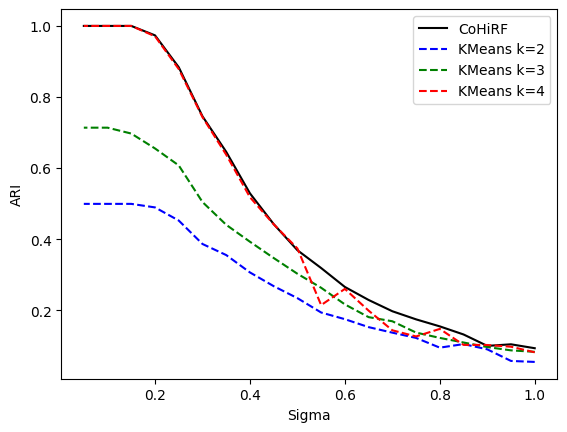

In [ ]:
n_samples=1000
n_features=2
#centers = np.array([[0.5,0],[-0.5,0],[0,np.sqrt(3)/2]])
centers = np.array([[0.5,0.5],[-0.5,0.5],[-0.5,-0.5],[0.5,-0.5]])
components_size= 1
base_model = KMeans
base_model_kwargs = {'n_clusters': 2}
random_state=13
sigma_list = np.arange(1,0,-0.05)
baseline_1 = KMeans(n_clusters=2, random_state=random_state)
baseline_2 = KMeans(n_clusters=3, random_state=random_state)
baseline_3 = KMeans(n_clusters=4, random_state=random_state)
repetitiones = [3,4,5,6,7,8]
trials = 1

ari = np.empty((trials,len(sigma_list),len(repetitiones)))
baseline_1_ari = np.empty((trials,len(sigma_list)))
baseline_2_ari = np.empty((trials,len(sigma_list)))
baseline_3_ari = np.empty((trials,len(sigma_list)))
for t in tqdm(range(trials)):
    for cluster_std_, cluster_std  in tqdm(enumerate(sigma_list), total=len(sigma_list)):
        X, true_labels = make_blobs(n_samples=n_samples, n_features=n_features, centers=centers, cluster_std=cluster_std,
                                    random_state=random_state)
        X = StandardScaler().fit_transform(X)
        baseline_1.fit(X)
        baseline_2.fit(X)
        baseline_3.fit(X)
        baseline_1_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_1.labels_)
        baseline_2_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_2.labels_)
        baseline_3_ari[t,cluster_std_] = adjusted_rand_score(true_labels, baseline_3.labels_)
        for rep_, rep in enumerate(repetitiones):
            model = ModularCoHiRF(n_features=components_size, repetitions = rep, random_state=random_state, 
                                  base_model=base_model, base_model_kwargs=base_model_kwargs)
            model.fit(X)
            ari[t,cluster_std_, rep_] = adjusted_rand_score(true_labels, model.labels_)
            #print(f"For sigma={cluster_std}: CoHiRF score is {model.score(X)}")

plt.fill_between(sigma_list, np.quantile(ari.max(axis=2),0.1,axis=0), np.quantile(ari.max(axis=2),0.9,axis=0),color='gray', alpha = 0.1)
plt.plot(sigma_list,ari.max(axis=2).mean(axis=0),'k',label='CoHiRF')
plt.plot(sigma_list,baseline_1_ari.mean(axis=0),'b--',label='KMeans k=2')
plt.plot(sigma_list,baseline_2_ari.mean(axis=0),'g--',label='KMeans k=3')
plt.plot(sigma_list,baseline_3_ari.mean(axis=0),'r--',label='KMeans k=4')
plt.xlabel('Sigma')
plt.ylabel('ARI')
plt.legend()

# Cocentric Circles

Text(0.5, 1.0, 'Kernel CoHiRF : ARI 0.981')

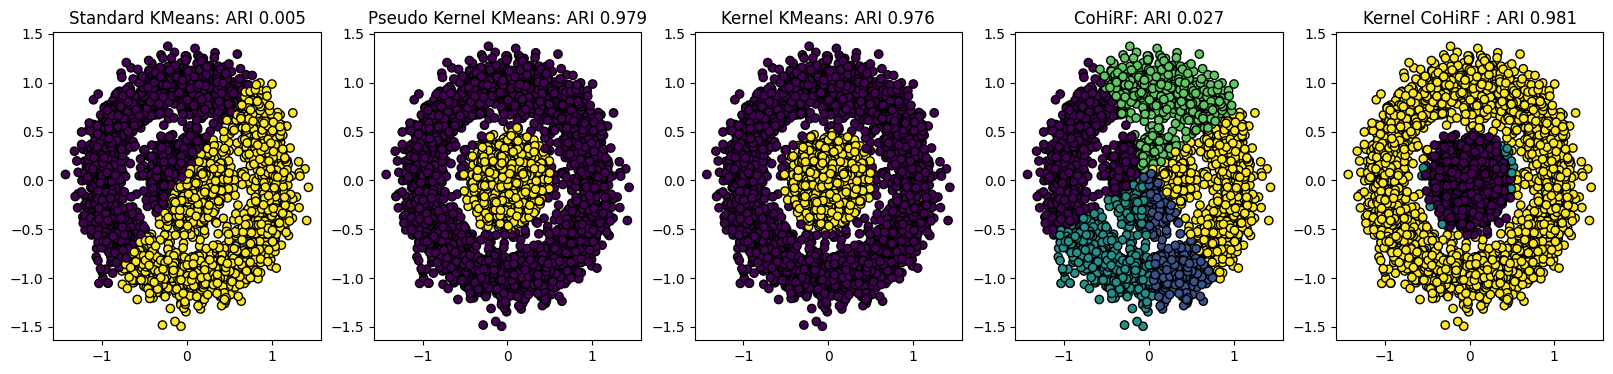

In [12]:
# dataset parameters
n_samples = 5000
factor = 0.15
noise = 0.15
random_state_dataset = 42
features, true_labels = make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=random_state_dataset)

random_state_model = 2000

# kmeans parameters
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state_model)
kmeans_labels = kmeans.fit_predict(features)
ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)

# pseudo kernel kmeans parameters
n_clusters = 2
gamma = 3
n_rff = 500
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}

pseudo_kernel_kmeans = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
pseudo_kernel_kmeans_labels = pseudo_kernel_kmeans.fit_predict(features)
ari_pseudo_kernel_kmeans = adjusted_rand_score(true_labels, pseudo_kernel_kmeans_labels)

# kernel kmeans parameters
gamma = 3
n_clusters = 2
kernel = 'rbf'

kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, random_state=random_state_model)
kernel_kmeans_labels = kernel_kmeans.fit_predict(features)
ari_kernel_kmeans = adjusted_rand_score(true_labels, kernel_kmeans_labels)

# cohirf parameters
n_features = 'full'
repetitions = 3
n_clusters = 2
representative_method = 'closest_overall'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
transform_method = 'random'
transform_kwargs = None

cohirf = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model)
cohirf_labels = cohirf.fit_predict(features)
ari_cohirf = adjusted_rand_score(true_labels, cohirf_labels)

# (pseudo) kernel cohirf parameters
n_features = 'full'
repetitions = 3
n_clusters = 2
representative_method = 'rbf'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
gamma = 3
n_rff = 500
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}

cohirf_kernel = ModularCoHiRFMod(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model)
cohirf_kernel_labels = cohirf_kernel.fit_predict(features)
ari_cohirf_kernel = adjusted_rand_score(true_labels, cohirf_kernel_labels)


fig, axs = plt.subplots(1, 5, figsize=(5*4, 4))
axs[0].scatter(features[:, 0], features[:, 1], c=kmeans_labels, cmap='viridis', edgecolor='k')
axs[0].set_title(f'Standard KMeans: ARI {ari_kmeans:.3f}')

axs[1].scatter(features[:, 0], features[:, 1], c=pseudo_kernel_kmeans_labels, cmap='viridis', edgecolor='k')
axs[1].set_title(f'Pseudo Kernel KMeans: ARI {ari_pseudo_kernel_kmeans:.3f}')

axs[2].scatter(features[:, 0], features[:, 1], c=kernel_kmeans_labels, cmap='viridis', edgecolor='k')
axs[2].set_title(f'Kernel KMeans: ARI {ari_kernel_kmeans:.3f}')

axs[3].scatter(features[:, 0], features[:, 1], c=cohirf_labels, cmap='viridis', edgecolor='k')
axs[3].set_title(f'CoHiRF: ARI {ari_cohirf:.3f}')

axs[4].scatter(features[:, 0], features[:, 1], c=cohirf_kernel_labels, cmap='viridis', edgecolor='k')
axs[4].set_title(f'Kernel CoHiRF : ARI {ari_cohirf_kernel:.3f}')


# How much we can vary with seed

In [13]:
n_samples = 5000
factor = 0.15
noise = 0.15
random_state_dataset = 42
features, true_labels = make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=random_state_dataset)


## RFF Aproximation (seed dependant)

In [14]:
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_dataset)

kmeans_n_clusters = 2
n_rff = 500
repetitions = 3
representative_method = 'rbf'
gamma = 3
model_cls = ModularCoHiRF
search_space = {
    'random_state': optuna.distributions.IntDistribution(0, 100),
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': representative_method,
    'repetitions': repetitions,
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': kmeans_n_clusters},
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': n_rff, 'gamma': gamma},
}
training_fn_cohirf = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
study = tuner.tune(training_fn=training_fn_cohirf, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-13 12:49:08,604] A new study created in memory with name: no-name-5e19d173-4791-4fce-bfc3-9fa8b1472d71


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

TypeError: ModularCoHiRF.__init__() got an unexpected keyword argument 'sampling_method'

In [ ]:
min_value = study.trials_dataframe()['value'].min()
max_value = study.trials_dataframe()['value'].max()
print(f"Best trial value: {max_value}")
print(f"Worst trial value: {min_value}")
print(f"Mean trial value: {study.trials_dataframe()['value'].mean()}")
print(f"Std trial value: {study.trials_dataframe()['value'].std()}")

Best trial value: 0.9777228970485992
Worst trial value: 8.642894379849716e-06
Mean trial value: 0.7777632699491701
Std trial value: 0.39899209801205027


## Nystroem Aproximation

In [ ]:
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_dataset)

kmeans_n_clusters = 2
n_rff = 500
repetitions = 3
representative_method = 'rbf'
gamma = 3
model_cls = ModularCoHiRF
search_space = {
    'random_state': optuna.distributions.IntDistribution(0, 100),
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': representative_method,
    'repetitions': repetitions,
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': kmeans_n_clusters},
    'sampling_method': Nystroem,
    'sampling_kwargs': {'kernel': 'rbf', 'gamma': gamma, 'n_components': n_rff},
}
training_fn_cohirf = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
study = tuner.tune(training_fn=training_fn_cohirf, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:23:08,115] A new study created in memory with name: no-name-f7c2489b-e9e1-4372-a696-fb86938bc730


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1020: UserWarning: n_components > n_samples. This is not possible.
n_co

In [ ]:
min_value = study.trials_dataframe()['value'].min()
max_value = study.trials_dataframe()['value'].max()
print(f"Best trial value: {max_value}")
print(f"Worst trial value: {min_value}")
print(f"Mean trial value: {study.trials_dataframe()['value'].mean()}")
print(f"Std trial value: {study.trials_dataframe()['value'].std()}")

Best trial value: 0.9761392275782216
Worst trial value: 0.9761392275782216
Mean trial value: 0.9761392275782217
Std trial value: 1.1390647892519134e-16


## True Kernel KMeans (not seed dependant)

In [ ]:
n_samples = 5000
factor = 0.15
noise = 0.15
random_state_dataset = 42
features, true_labels = make_circles(n_samples=n_samples, factor=factor, noise=noise, random_state=random_state_dataset)

tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_dataset)

kmeans_n_clusters = 2
n_rff = 500
repetitions = 3
representative_method = 'rbf'
gamma = 3
model_cls = ModularCoHiRF
search_space = {
    'random_state': optuna.distributions.IntDistribution(0, 100),
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': representative_method,
    'repetitions': repetitions,
    'base_model': KernelKMeans,
    'base_model_kwargs': {'n_clusters': kmeans_n_clusters, 'kernel': 'rbf', 'gamma': gamma},
}
training_fn_cohirf = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
study = tuner.tune(training_fn=training_fn_cohirf, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:24:05,196] A new study created in memory with name: no-name-5edd5e86-2c74-4bab-915c-ec78703688e8


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
min_value = study.trials_dataframe()['value'].min()
max_value = study.trials_dataframe()['value'].max()
print(f"Best trial value: {max_value}")
print(f"Worst trial value: {min_value}")
print(f"Mean trial value: {study.trials_dataframe()['value'].mean()}")
print(f"Std trial value: {study.trials_dataframe()['value'].std()}")

Best trial value: 0.9761392275782216
Worst trial value: 0.9761392275782216
Mean trial value: 0.9761392275782217
Std trial value: 1.1390647892519134e-16


# Cocentric Spheres

## Base

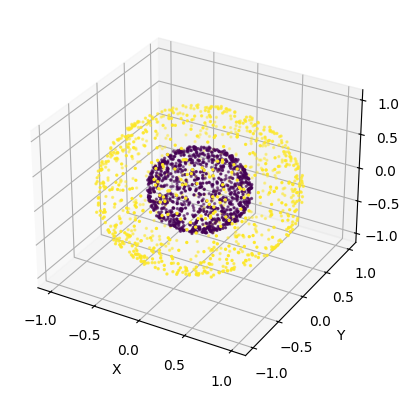

In [14]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01                 # Standard deviation for the radii
seed_dataset = 42
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=seed_dataset)

visualize_3d_data(features, true_labels)

In [15]:
# kmeans parameters
n_clusters = 2
random_state_model = 42000

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state_model)
kmeans_labels = kmeans.fit_predict(features)
ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)


In [ ]:
# pseudo kernel kmeans parameters
n_clusters = 2
gamma = 10
n_rff = 500
random_state_model = 42000
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff, 'random_state': random_state_model}
pseudo_kernel_kmeans = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
pseudo_kernel_kmeans_labels = pseudo_kernel_kmeans.fit_predict(features)
ari_pseudo_kernel_kmeans = adjusted_rand_score(true_labels, pseudo_kernel_kmeans_labels)


In [17]:
# kernel kmeans parameters
gamma = 10
n_clusters = 2
kernel = 'rbf'
random_state_model = 42000
kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, random_state=random_state_model)
kernel_kmeans_labels = kernel_kmeans.fit_predict(features)
ari_kernel_kmeans = adjusted_rand_score(true_labels, kernel_kmeans_labels)


In [ ]:
# kernel cohirf parameters
random_state_model = 42000
n_features = 'full'
repetitions = 4
n_clusters = 2
representative_method = 'rbf'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
gamma = 10
n_rff = 500
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
cohirf_kernel = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model)
cohirf_kernel_labels = cohirf_kernel.fit_predict(features)
ari_cohirf_kernel = adjusted_rand_score(true_labels, cohirf_kernel_labels)

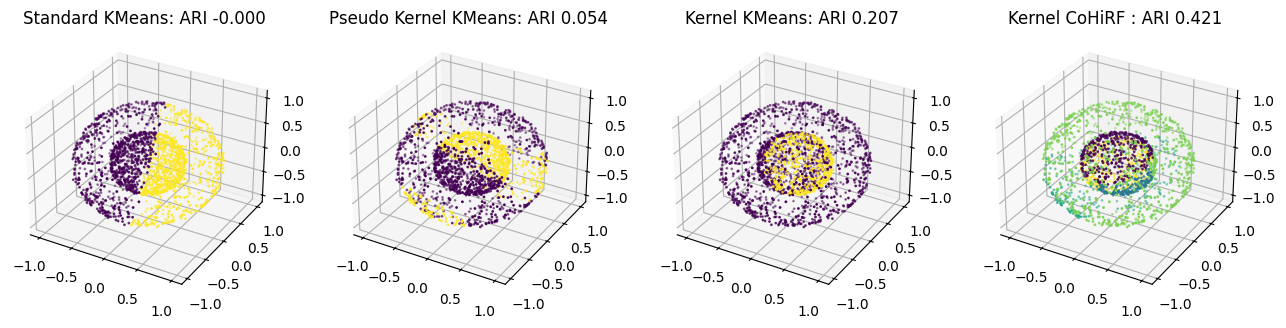

In [19]:

fig, axs = plt.subplots(1, 4, figsize=(4*4, 4), subplot_kw={'projection': '3d'})

axs[0].scatter(features[:, 0], features[:, 1], features[:, 2], c=kmeans_labels, cmap='viridis', s=1)
axs[0].set_title(f'Standard KMeans: ARI {ari_kmeans:.3f}')

axs[1].scatter(features[:, 0], features[:, 1], features[:, 2], c=pseudo_kernel_kmeans_labels, cmap='viridis', s=1)
axs[1].set_title(f'Pseudo Kernel KMeans: ARI {ari_pseudo_kernel_kmeans:.3f}')

axs[2].scatter(features[:, 0], features[:, 1], features[:, 2], c=kernel_kmeans_labels, cmap='viridis', s=1)
axs[2].set_title(f'Kernel KMeans: ARI {ari_kernel_kmeans:.3f}')

axs[3].scatter(features[:, 0], features[:, 1], features[:, 2], c=cohirf_kernel_labels, cmap='viridis', s=1)
axs[3].set_title(f'Kernel CoHiRF : ARI {ari_cohirf_kernel:.3f}')
plt.show()

## Optimization CoHiRF KernelKmeans Vladi

In [20]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 'full',
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:29:03,087] A new study created in memory with name: no-name-d5b8285c-c272-41a4-8cf8-b82c1841eba4


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

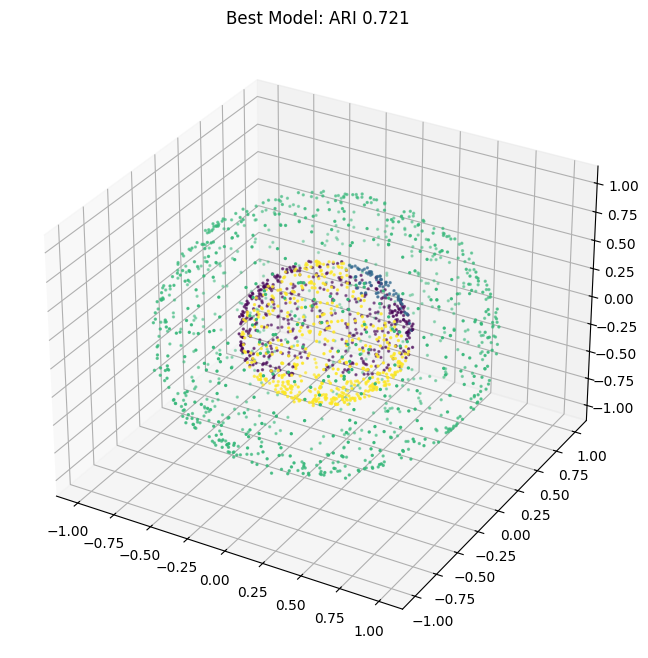

In [21]:
best_params_cohirf_vlad = study.best_params
best_params_cohirf_vlad = unflatten_dict(best_params_cohirf_vlad)
best_params_cohirf_vlad = update_recursively(best_params_cohirf_vlad, model_kwargs)
best_model_cohirf_vlad = model_cls(**best_params_cohirf_vlad)
labels_cohirf_vlad = best_model_cohirf_vlad.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_cohirf_vlad, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_cohirf_vlad):.3f}')
plt.show()

In [22]:
best_params_cohirf_vlad

{'repetitions': 4,
 'sampling_kwargs': {'gamma': 8.189719601223231, 'n_components': 500},
 'base_model_kwargs': {'n_clusters': 4},
 'n_features': 'full',
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'sampling_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 42000}

## Optimization Kernel CoHiRF sampling

In [23]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=100, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:31:13,940] A new study created in memory with name: no-name-79cd53fb-7fc2-4295-8a24-da4e548fbb13


Trials:   0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
study.best_value

0.13728534009211024

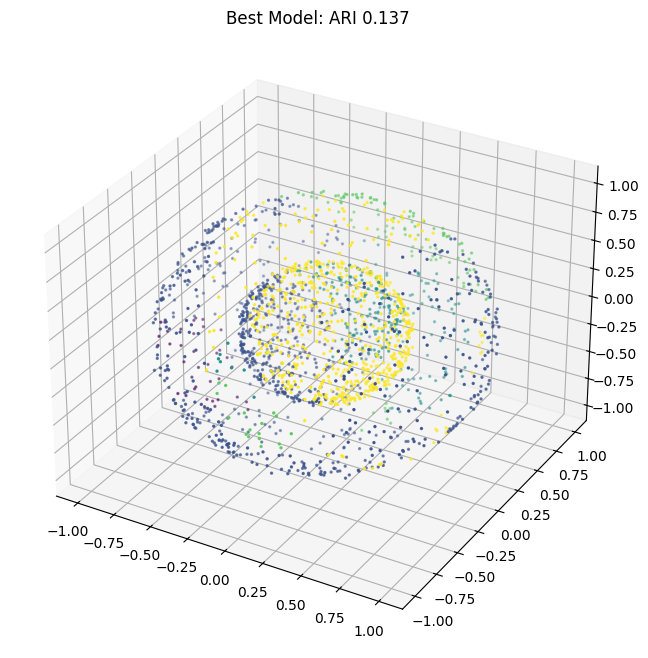

In [ ]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

In [27]:
best_params_kernel_cohirf

{'repetitions': 3,
 'sampling_kwargs': {'gamma': 0.8399362526041153, 'n_components': 500},
 'base_model_kwargs': {'n_clusters': 3},
 'n_features': 2,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'sampling_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 42000}

## Optimization Kernel Kmeans

In [28]:
random_state_model = 42000
model_cls = KernelKMeans
search_space = {
    'gamma': optuna.distributions.FloatDistribution(0.1, 20),
}
model_kwargs = {
    'n_clusters': 2,
    'kernel': 'rbf',
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:35:49,158] A new study created in memory with name: no-name-8a106837-2efa-4825-af04-e93bf57e6961


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

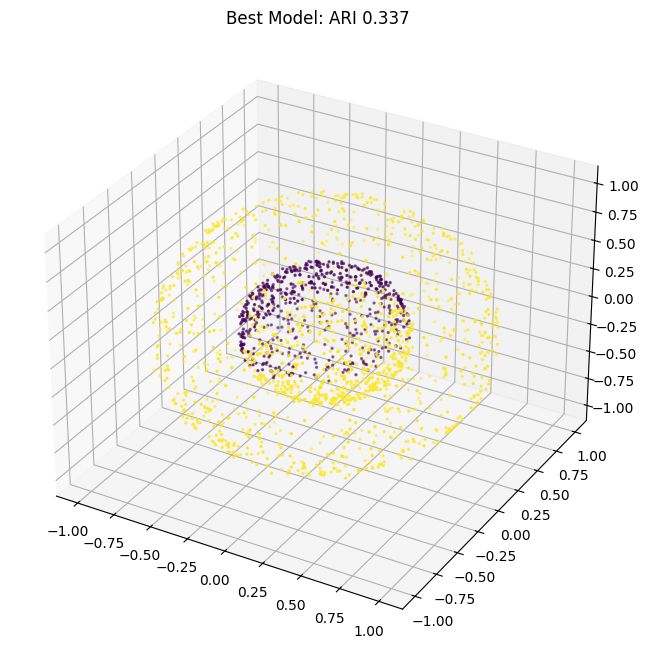

In [29]:
best_params_kernel_kmeans = study.best_params
best_params_kernel_kmeans = unflatten_dict(best_params_kernel_kmeans)
best_params_kernel_kmeans = update_recursively(best_params_kernel_kmeans, model_kwargs)
best_model_kernel_kmeans = model_cls(**best_params_kernel_kmeans)
labels_kernel_kmeans = best_model_kernel_kmeans.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_kmeans, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_kmeans):.3f}')
plt.show()

In [30]:
best_params_kernel_kmeans

{'gamma': 6.975480883180408,
 'n_clusters': 2,
 'kernel': 'rbf',
 'random_state': 42000}

## Optimization (Approx.) Kernel Kmeans

In [31]:
random_state_model = 42000
model_cls = PseudoKernelClustering
search_space = {
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2 ,'random_state': random_state_model},
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500, 'random_state': random_state_model},
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:36:55,105] A new study created in memory with name: no-name-3a3f97c6-dc70-4a99-81f4-01be4fed340a


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

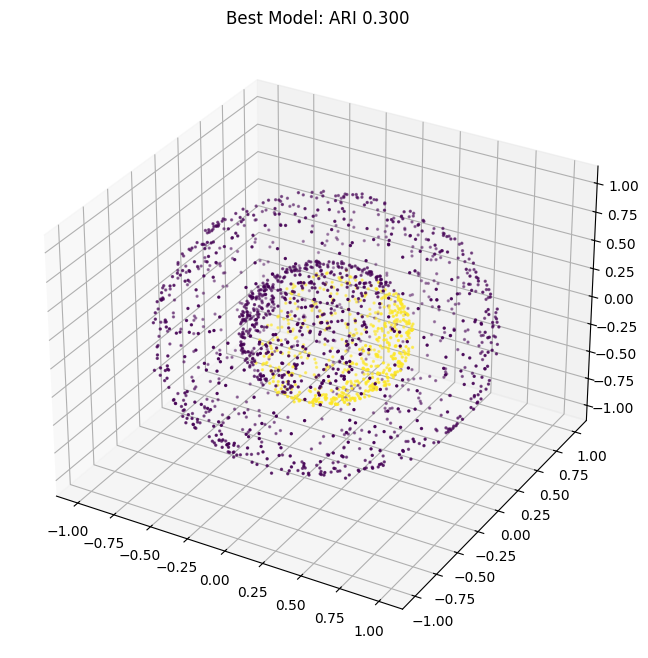

In [32]:
best_params_pseudo_kernel_kmeans = study.best_params
best_params_pseudo_kernel_kmeans = unflatten_dict(best_params_pseudo_kernel_kmeans)
best_params_pseudo_kernel_kmeans = update_recursively(best_params_pseudo_kernel_kmeans, model_kwargs)
best_model_pseudo_kernel_kmeans = model_cls(**best_params_pseudo_kernel_kmeans)
labels_pseudo_kernel_kmeans = best_model_pseudo_kernel_kmeans.fit_predict(features)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_pseudo_kernel_kmeans, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_pseudo_kernel_kmeans):.3f}')
plt.show()

In [33]:
best_params_pseudo_kernel_kmeans

{'sampling_kwargs': {'gamma': 19.939919998571046,
  'n_components': 500,
  'random_state': 42000},
 'base_model': sklearn.cluster._kmeans.KMeans,
 'base_model_kwargs': {'n_clusters': 2, 'random_state': 42000},
 'sampling_method': sklearn.kernel_approximation.RBFSampler}

# Cocentric Spheres + radius

## Base

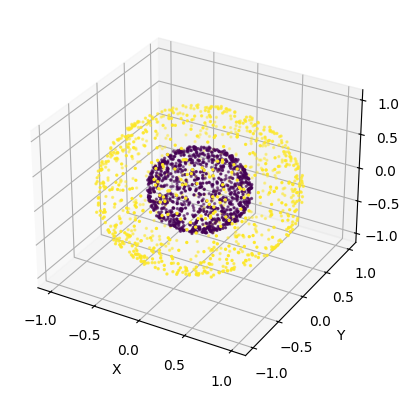

In [4]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01                 # Standard deviation for the radii
seed_dataset = 42
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=seed_dataset)

visualize_3d_data(features, true_labels)

features_extended = np.hstack((features,np.sum(features**2, axis=1, keepdims=True)))

In [34]:
# kmeans parameters
n_clusters = 2
random_state_model = 42

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state_model)
kmeans_labels = kmeans.fit_predict(features_extended)
ari_kmeans = adjusted_rand_score(true_labels, kmeans_labels)

# pseudo kernel kmeans parameters
n_clusters = 2
gamma = 2
n_rff = 500
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
pseudo_kernel_kmeans = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
pseudo_kernel_kmeans_labels = pseudo_kernel_kmeans.fit_predict(features_extended)
ari_pseudo_kernel_kmeans = adjusted_rand_score(true_labels, pseudo_kernel_kmeans_labels)

# kernel kmeans parameters
gamma = 2
n_clusters = 2
kernel = 'rbf'
kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, random_state=random_state_model)
kernel_kmeans_labels = kernel_kmeans.fit_predict(features_extended)
ari_kernel_kmeans = adjusted_rand_score(true_labels, kernel_kmeans_labels)

# kernel cohirf parameters
random_state_model = 13
n_features = 2
repetitions = 3
n_clusters = 2
representative_method = 'rbf'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
gamma = 3
n_rff = 500
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
cohirf_kernel = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model, sample_than_transform=True)
cohirf_kernel_labels = cohirf_kernel.fit_predict(features_extended)
ari_cohirf_kernel = adjusted_rand_score(true_labels, cohirf_kernel_labels)



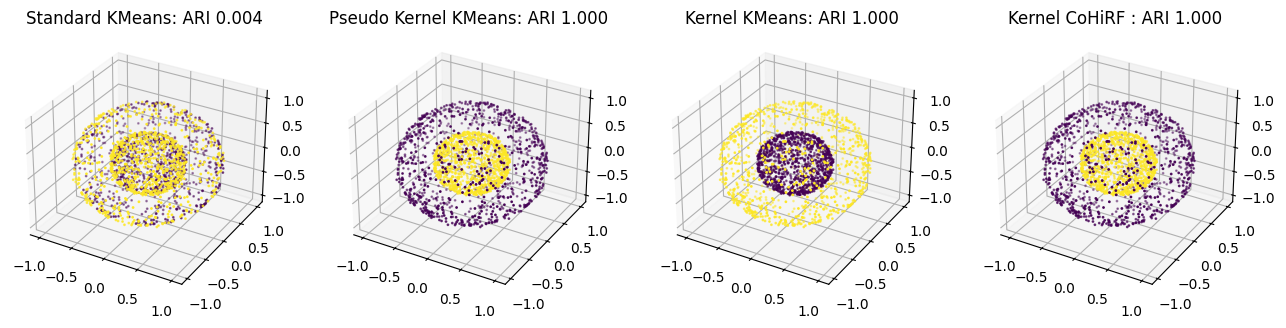

In [35]:
fig, axs = plt.subplots(1, 4, figsize=(4*4, 4), subplot_kw={'projection': '3d'})

axs[0].scatter(features[:, 0], features[:, 1], features[:, 2], c=kmeans_labels, cmap='viridis', s=1)
axs[0].set_title(f'Standard KMeans: ARI {ari_kmeans:.3f}')

axs[1].scatter(features[:, 0], features[:, 1], features[:, 2], c=pseudo_kernel_kmeans_labels, cmap='viridis', s=1)
axs[1].set_title(f'Pseudo Kernel KMeans: ARI {ari_pseudo_kernel_kmeans:.3f}')

axs[2].scatter(features[:, 0], features[:, 1], features[:, 2], c=kernel_kmeans_labels, cmap='viridis', s=1)
axs[2].set_title(f'Kernel KMeans: ARI {ari_kernel_kmeans:.3f}')

axs[3].scatter(features[:, 0], features[:, 1], features[:, 2], c=cohirf_kernel_labels, cmap='viridis', s=1)
axs[3].set_title(f'Kernel CoHiRF : ARI {ari_cohirf_kernel:.3f}')
plt.show()

## KPCA Kmeans

In [7]:
n_clusters = 2
kernel = 'rbf'
gamma = 3
n_components = 3
random_state_model = 42
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = KernelPCA
transform_kwargs = dict(kernel=kernel, n_components=n_components, gamma=gamma)
model = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
labels = model.fit_predict(features_extended)
ari = adjusted_rand_score(true_labels, labels)

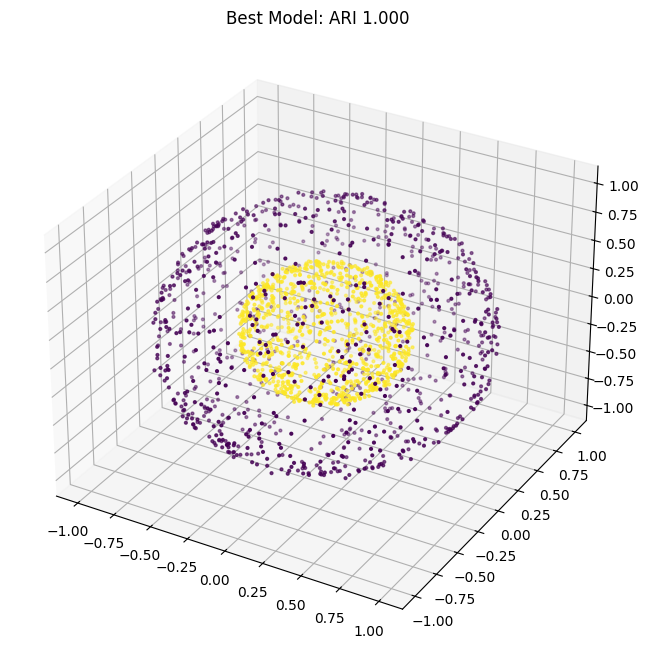

In [8]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=4)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## HDBSCAN

In [9]:
model = HDBSCAN(min_cluster_size=5)
labels = model.fit_predict(features_extended)
ari = adjusted_rand_score(true_labels, labels)

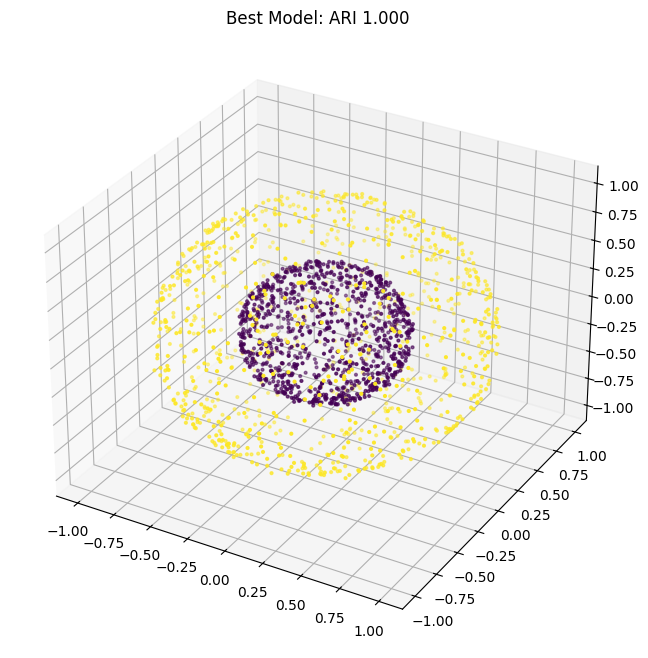

In [10]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=4)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## DBSCAN

In [11]:
model = DBSCAN(eps=0.5, min_samples=5)
labels = model.fit_predict(features_extended)
ari = adjusted_rand_score(true_labels, labels)

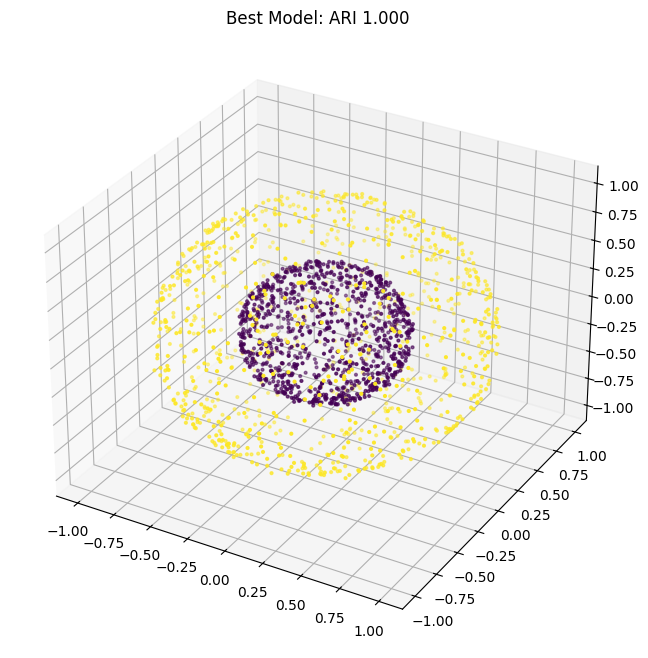

In [12]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=4)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## Optimization kernel cohirf

### Seed 13

In [ ]:
random_state_model = 13
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:38:58,040] A new study created in memory with name: no-name-fbe559a2-3aea-47ce-b434-f45d8c112610


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [57]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.094396 2025-05-09 13:38:58.048406 2025-05-09 13:39:00.990622   
1        1  0.047185 2025-05-09 13:39:00.991301 2025-05-09 13:39:04.005266   
2        2  0.058501 2025-05-09 13:39:04.006032 2025-05-09 13:39:05.471439   
3        3  0.200880 2025-05-09 13:39:05.472069 2025-05-09 13:39:07.075928   
4        4  0.369779 2025-05-09 13:39:07.076644 2025-05-09 13:39:07.415485   
5        5  0.132976 2025-05-09 13:39:07.416216 2025-05-09 13:39:09.087753   
6        6  0.121154 2025-05-09 13:39:09.088458 2025-05-09 13:39:09.477658   
7        7  0.435936 2025-05-09 13:39:09.478407 2025-05-09 13:39:10.281465   
8        8  0.436176 2025-05-09 13:39:10.282190 2025-05-09 13:39:10.624461   
9        9  0.053767 2025-05-09 13:39:10.625178 2025-05-09 13:39:13.439628   
10      10  0.457522 2025-05-09 13:39:13.440247 2025-05-09 13:39:13.805657   
11      11  0.729591 2025-05-09 13:39:13.806469 2025-05-09 13:39:14.382747   
12      12  0.813899 2025-05-09 13:39:14.383497 2025-05-09 13:39:14.961395   
13      13  0.771764 2025-05-09 13:39:14.962039 2025-05-09 13:39:15.581190   
14      14  0.562865 2025-05-09 13:39:15.584941 2025-05-09 13:39:16.467645   
15      15  0.430049 2025-05-09 13:39:16.473719 2025-05-09 13:39:17.245072   
16      16  1.000000 2025-05-09 13:39:17.246562 2025-05-09 13:39:17.677849   
17      17  1.000000 2025-05-09 13:39:17.678764 2025-05-09 13:39:18.104530   
18      18  0.381976 2025-05-09 13:39:18.105391 2025-05-09 13:39:18.498023   
19      19  1.000000 2025-05-09 13:39:18.498737 2025-05-09 13:39:18.859020   

                 duration  params_base_model_kwargs/n_clusters  \
0  0 days 00:00:02.942216                                    9   
1  0 days 00:00:03.013965                                    6   
2  0 days 00:00:01.465407                                    7   
3  0 days 00:00:01.603859                                    4   
4  0 days 00:00:00.338841                                    5   
5  0 days 00:00:01.671537                                    5   
6  0 days 00:00:00.389200                                   10   
7  0 days 00:00:00.803058                                   10   
8  0 days 00:00:00.342271                                    7   
9  0 days 00:00:02.814450                                    8   
10 0 days 00:00:00.365410                                    4   
11 0 days 00:00:00.576278                                    5   
12 0 days 00:00:00.577898                                    3   
13 0 days 00:00:00.619151                                    2   
14 0 days 00:00:00.882704                                    3   
15 0 days 00:00:00.771353                                    2   
16 0 days 00:00:00.431287                                    2   
17 0 days 00:00:00.425766                                    2   
18 0 days 00:00:00.392632                                    4   
19 0 days 00:00:00.360283                                    2   

    params_repetitions  params_sampling_kwargs/gamma  user_attrs_result  \
0                    8                      7.202482           0.094396   
1                   10                     29.180773           0.047185   
2                    7                     23.288243           0.058501   
3                    8                      1.147592           0.200880   
4                    2                     25.726122           0.369779   
5                    8                      7.762770           0.132976   
6                    2                     10.814180           0.121154   
7                    3                      9.649802           0.435936   
8                    2                      2.046028           0.436176   
9                    9                      0.360600           0.053767   
10                   2                      5.588019           0.457522   
11                   3                      3.562946           0.729591   
12 

In [58]:
study.best_value

1.0

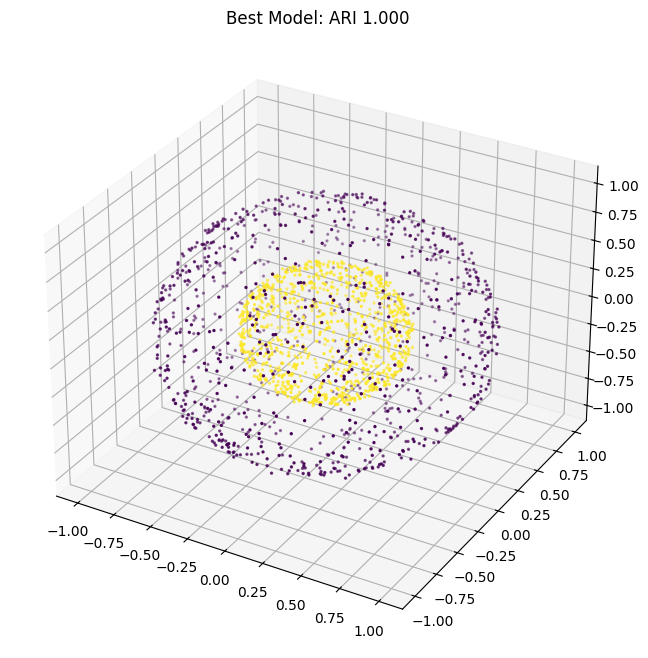

In [ ]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

In [60]:
best_params_kernel_cohirf

{'repetitions': 2,
 'sampling_kwargs': {'gamma': 3.130760691303247, 'n_components': 500},
 'base_model_kwargs': {'n_clusters': 2},
 'n_features': 2,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'sampling_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 13,
 'sample_than_transform': True}

### Seed 42000

In [89]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:57:29,531] A new study created in memory with name: no-name-0bcb5764-8ace-471f-a88f-edc9c4d22161


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [90]:
study.best_value

0.6510809548976532

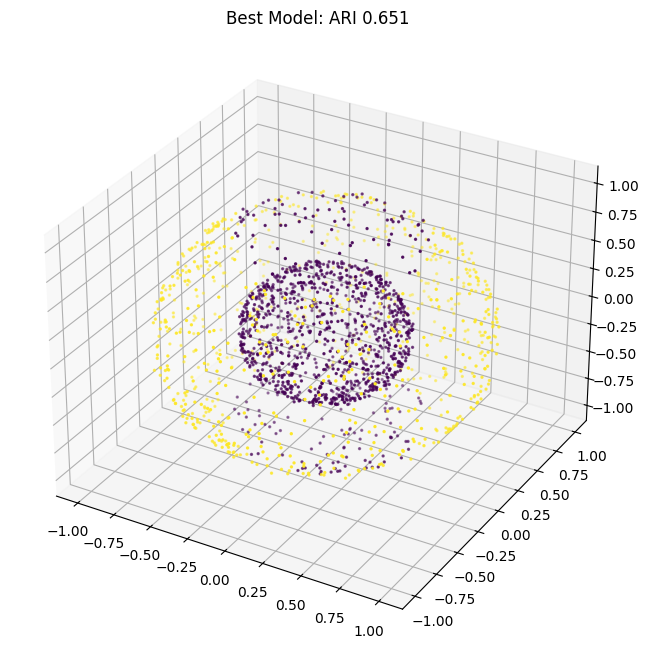

In [ ]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

### Seed 13 transform then sample

In [92]:
random_state_model = 13
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 0.5,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': False,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:58:03,746] A new study created in memory with name: no-name-59a1927f-530d-4304-a0c5-02bf9cbe4009


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [93]:
study.best_value

1.0

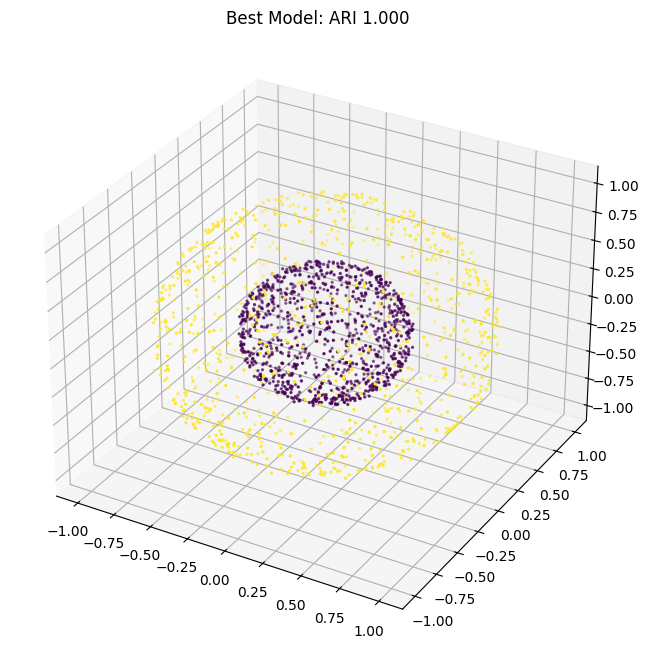

In [ ]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

In [95]:
best_params_kernel_cohirf

{'repetitions': 5,
 'sampling_kwargs': {'gamma': 2.237489570922963, 'n_components': 500},
 'base_model_kwargs': {'n_clusters': 2},
 'n_features': 0.5,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'sampling_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 13,
 'sample_than_transform': False}

### Seed 13 transform once then sample

In [96]:
random_state_model = 13
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 0.5,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': False,
    'transform_once_per_iteration': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:58:28,129] A new study created in memory with name: no-name-87f1941b-76f6-4980-be25-5ae008502d65


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [97]:
study.best_value

1.0

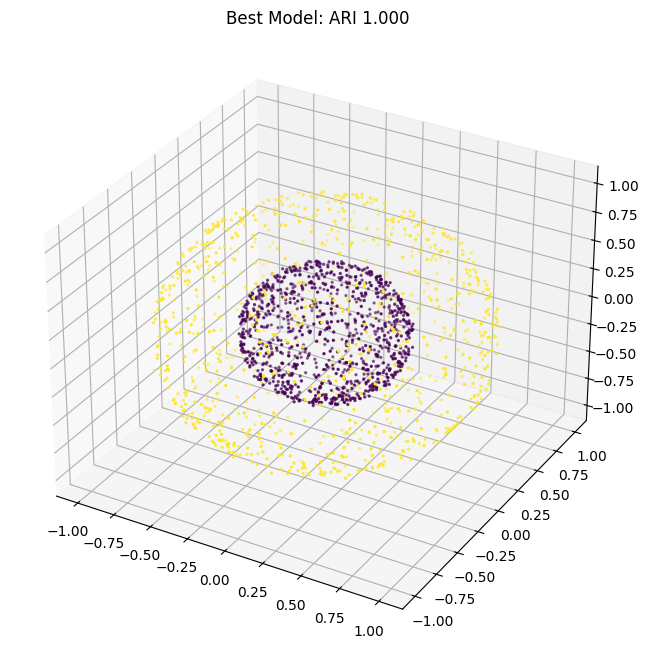

In [ ]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

### Seed 42000 transform then sample

In [99]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 0.5,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': False,
    'transform_once_per_iteration': False,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:58:49,451] A new study created in memory with name: no-name-a2fc6e14-144a-4423-954a-3a5bf254da4c


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [100]:
study.best_value

0.7683532917219453

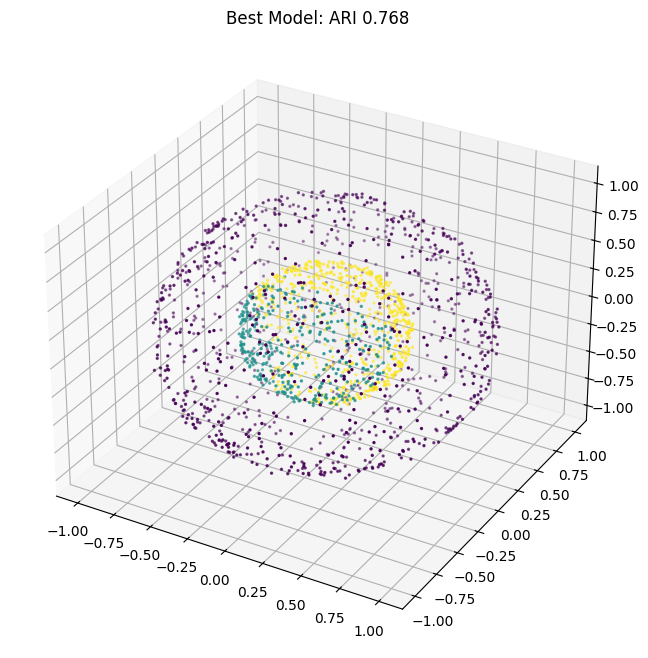

In [ ]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf, max_iter=8)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

### Seed 42000 transform once then sample

In [102]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 30),
        },
    'base_model_kwargs': {
        'n_clusters': optuna.distributions.IntDistribution(2, 10),
    }
}
model_kwargs = {
    'n_features': 0.5,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': False,
    'transform_once_per_iteration': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 13:59:18,045] A new study created in memory with name: no-name-c088bf60-c0bd-4d68-83f9-afb47742b7b9


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [103]:
study.best_value

0.603117717468637

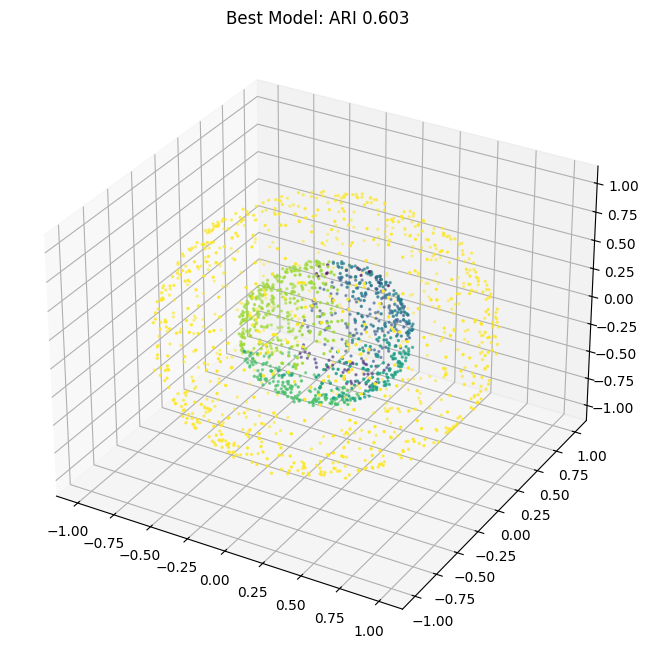

In [ ]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

### Seed 42000 fixed number of clusters for KMeans

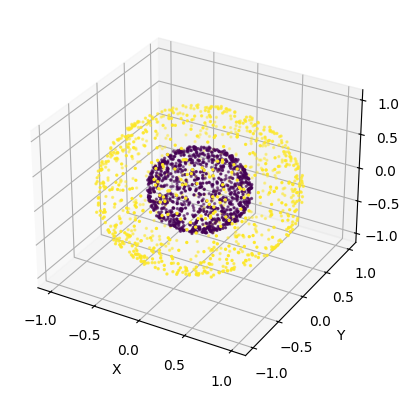

In [105]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.01                 # Standard deviation for the radii
seed_dataset = 42
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=seed_dataset)

visualize_3d_data(features, true_labels)

features_extended = np.hstack((features,np.sum(features**2, axis=1, keepdims=True)))

In [106]:
random_state_model = 42000
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2},
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 14:22:54,445] A new study created in memory with name: no-name-ba2ae69c-34f5-4129-98cb-43f1b42ff30b


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

In [107]:
study.best_value

1.0

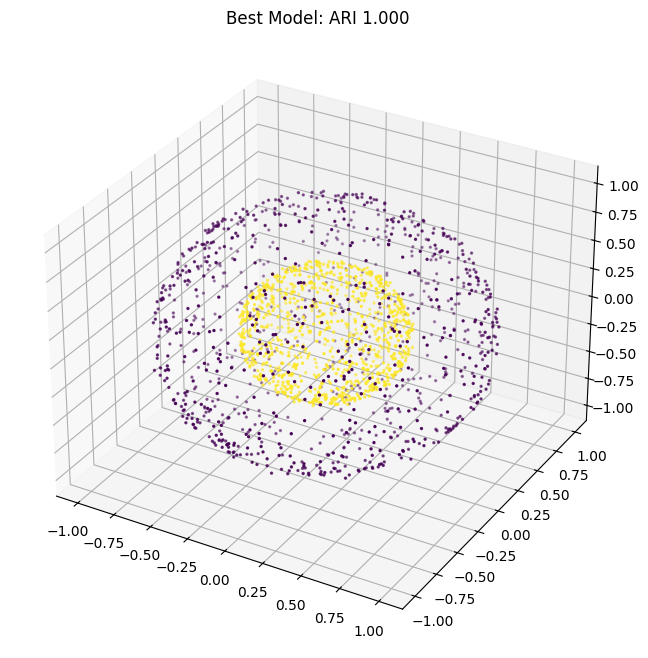

In [ ]:
best_params_kernel_cohirf = study.best_params
best_params_kernel_cohirf = unflatten_dict(best_params_kernel_cohirf)
best_params_kernel_cohirf = update_recursively(best_params_kernel_cohirf, model_kwargs)
best_model_kernel_cohirf = model_cls(**best_params_kernel_cohirf)
labels_kernel_cohirf = best_model_kernel_cohirf.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels_kernel_cohirf, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels_kernel_cohirf):.3f}')
plt.show()

In [ ]:
best_params_kernel_cohirf

{'repetitions': 4,
 'sampling_kwargs': {'gamma': 9.79200930288217, 'n_components': 500},
 'n_features': 2,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'base_model_kwargs': {'n_clusters': 2},
 'sampling_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 42000,
 'sample_than_transform': True}

## Optimization Kernel Kmeans

In [114]:
random_state_model = 13
model_cls = KernelKMeans
search_space = {
    'gamma': optuna.distributions.FloatDistribution(0.1, 20),
}
model_kwargs = {
    'n_clusters': 2,
    'kernel': 'rbf',
    'random_state': random_state_model,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 14:27:58,546] A new study created in memory with name: no-name-e9a949cf-d7a0-413c-92d2-628a914c9983


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

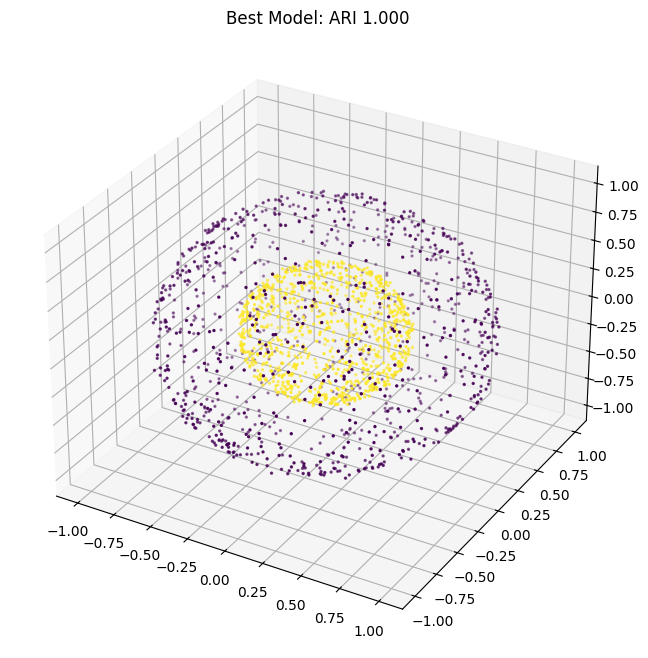

In [115]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

In [116]:
best_params

{'gamma': 4.028263121618731,
 'n_clusters': 2,
 'kernel': 'rbf',
 'random_state': 13}

## Optimization (Approx.) Kernel Kmeans

In [117]:
random_state_model = 42000
model_cls = PseudoKernelClustering
search_space = {
    'sampling_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2 ,'random_state': random_state_model},
    'sampling_method': RBFSampler,
    'sampling_kwargs': {'n_components': 500, 'random_state': random_state_model},
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 14:35:14,980] A new study created in memory with name: no-name-6c73f6c4-1e18-406f-9e34-67c066d679b0


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

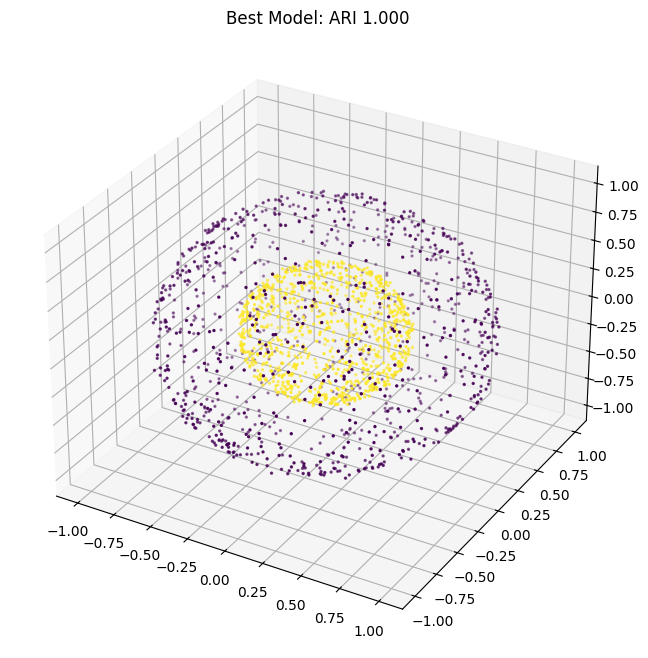

In [118]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

In [119]:
best_params

{'sampling_kwargs': {'gamma': 2.435332138564481,
  'n_components': 500,
  'random_state': 42000},
 'base_model': sklearn.cluster._kmeans.KMeans,
 'base_model_kwargs': {'n_clusters': 2, 'random_state': 42000},
 'sampling_method': sklearn.kernel_approximation.RBFSampler}

# Hard Cocentric Spheres

## Base

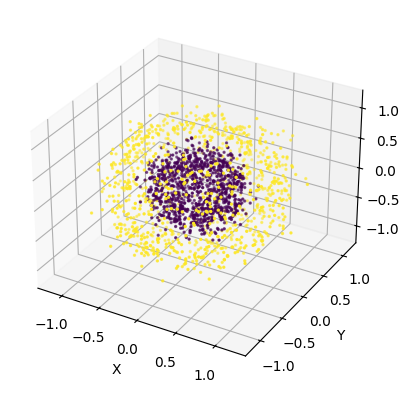

In [98]:
# dataset parameters
mean_r = [0.5, 1]  # Mean radii of the spheres
std = 0.1 # Standard deviation for the radii
seed_dataset = 42
features, true_labels = generate_spherical_clusters(mean_r, std, num_points_per_sphere=1000, seed=seed_dataset)

visualize_3d_data(features, true_labels)

features_extended = np.hstack((features,np.sum(features**2, axis=1, keepdims=True)))

In [99]:
random_state_model = 42

# pseudo kernel kmeans parameters
n_clusters = 2
gamma = 2
n_rff = 500
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters, 'random_state': random_state_model}
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
pseudo_kernel_kmeans = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
pseudo_kernel_kmeans_labels = pseudo_kernel_kmeans.fit_predict(features_extended)
ari_pseudo_kernel_kmeans = adjusted_rand_score(true_labels, pseudo_kernel_kmeans_labels)

# kernel kmeans parameters
gamma = 2
n_clusters = 2
kernel = 'rbf'
kernel_kmeans = KernelKMeans(n_clusters=n_clusters, kernel=kernel, gamma=gamma, random_state=random_state_model)
kernel_kmeans_labels = kernel_kmeans.fit_predict(features_extended)
ari_kernel_kmeans = adjusted_rand_score(true_labels, kernel_kmeans_labels)

# kernel cohirf parameters
random_state_model = 13
n_features = 2
repetitions = 3
n_clusters = 2
representative_method = 'rbf'
base_model = KMeans
base_model_kwargs = {'n_clusters': n_clusters}
gamma = 3
n_rff = 500
transform_method = RBFSampler
transform_kwargs = {'gamma': gamma, 'n_components': n_rff}
cohirf_kernel = ModularCoHiRF(n_features=n_features, repetitions=repetitions, representative_method=representative_method,
                        base_model=base_model, base_model_kwargs=base_model_kwargs,
                        transform_method=transform_method, transform_kwargs=transform_kwargs, random_state=random_state_model, sample_than_transform=True)
cohirf_kernel_labels = cohirf_kernel.fit_predict(features_extended)
ari_cohirf_kernel = adjusted_rand_score(true_labels, cohirf_kernel_labels)

In [100]:
# HDBSCAN parameters
min_cluster_size = 20
hdbscan = HDBSCAN(min_cluster_size=min_cluster_size)
hdbscan_labels = hdbscan.fit_predict(features_extended)
ari_hdbscan = adjusted_rand_score(true_labels, hdbscan_labels)

In [101]:
# DBSCAN parameters
eps = 1
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(features_extended)
ari_dbscan = adjusted_rand_score(true_labels, dbscan_labels)


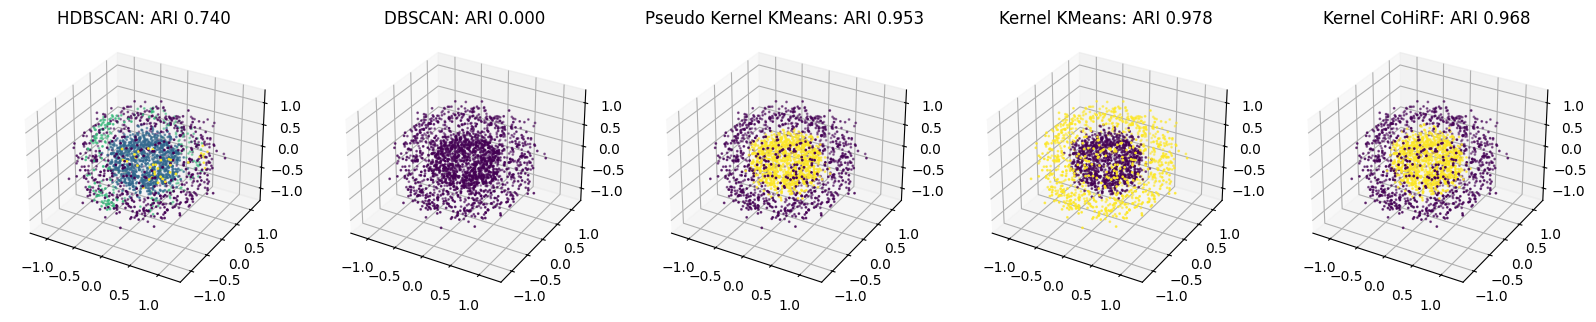

In [102]:
labels_list = [hdbscan_labels, dbscan_labels, pseudo_kernel_kmeans_labels, kernel_kmeans_labels, cohirf_kernel_labels]
ari_list = [ari_hdbscan, ari_dbscan, ari_pseudo_kernel_kmeans, ari_kernel_kmeans, ari_cohirf_kernel]
labels_names = ['HDBSCAN', 'DBSCAN', 'Pseudo Kernel KMeans', 'Kernel KMeans', 'Kernel CoHiRF']

n_figs = len(labels_list)

fig, axs = plt.subplots(1, n_figs, figsize=(4*n_figs, 4), subplot_kw={'projection': '3d'})

for i, (label, ari, name) in enumerate(zip(labels_list, ari_list, labels_names)):
    axs[i].scatter(features[:, 0], features[:, 1], features[:, 2], c=label, cmap='viridis', s=1)
    axs[i].set_title(f'{name}: ARI {ari:.3f}')
    i += 1
plt.show()

## KPCA HDBSCAN

In [82]:
kernel = 'rbf'
gamma = 2
n_components = 3
random_state_model = 42
base_model = HDBSCAN
base_model_kwargs = {'min_cluster_size': 5}
transform_method = KernelPCA
transform_kwargs = dict(kernel=kernel, n_components=n_components, gamma=gamma)
model = PseudoKernelClustering(base_model=base_model, base_model_kwargs=base_model_kwargs,
                                              transform_method=transform_method, transform_kwargs=transform_kwargs)
labels = model.fit_predict(features_extended)
ari = adjusted_rand_score(true_labels, labels)

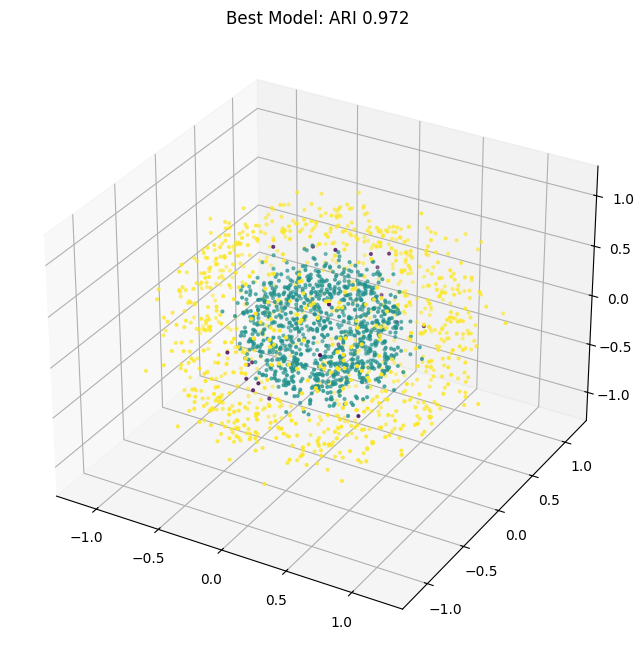

In [83]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=4)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## Optimization Approx Kernel Kmeans

In [ ]:
random_state_model = 42000
model_cls = PseudoKernelClustering
search_space = {
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2 ,'random_state': random_state_model},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500, 'random_state': random_state_model},
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=20, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

[I 2025-05-09 15:16:15,600] A new study created in memory with name: no-name-f0be27ab-0619-4278-8f6e-57d1aa50e5a1


Trials:   0%|          | 0/20 [00:00<?, ?it/s]

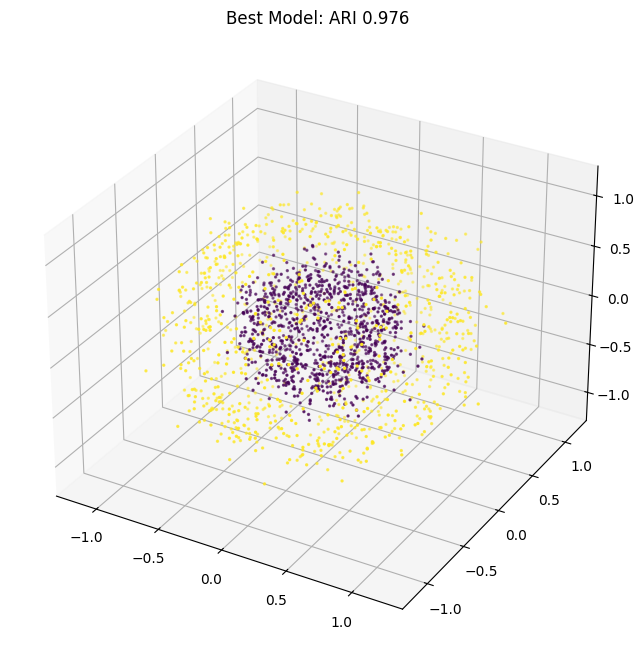

In [87]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

## Optimization Kernel Cohirf

In [105]:
random_state_model = 13
model_cls = ModularCoHiRF
search_space = {
    'repetitions': optuna.distributions.IntDistribution(2, 10),
    'transform_kwargs': {
        'gamma': optuna.distributions.FloatDistribution(0.1, 20),
        },
}
model_kwargs = {
    'n_features': 2,
    'representative_method': 'rbf',
    'base_model': KMeans,
    'base_model_kwargs': {'n_clusters': 2},
    'transform_method': RBFSampler,
    'transform_kwargs': {'n_components': 500},
    'random_state': random_state_model,
    'sample_than_transform': True,
}
training_fn = partial(training_fn, model_cls=model_cls, model_kwargs=model_kwargs, features=features_extended,
                             true_labels=true_labels)
tuner = OptunaTuner(sampler='tpe', n_trials=50, seed=random_state_model)
study = tuner.tune(training_fn=training_fn, search_space=search_space, direction='maximize')

/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/home/belucci/miniconda3/envs/cohirf/lib/python3.11/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``constant_liar`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-05-09 15:23:59,023] A new study created in memory with name: no-name-8c1fe430-1613-4cd8-b241-e57dae667c50


Trials:   0%|          | 0/50 [00:00<?, ?it/s]

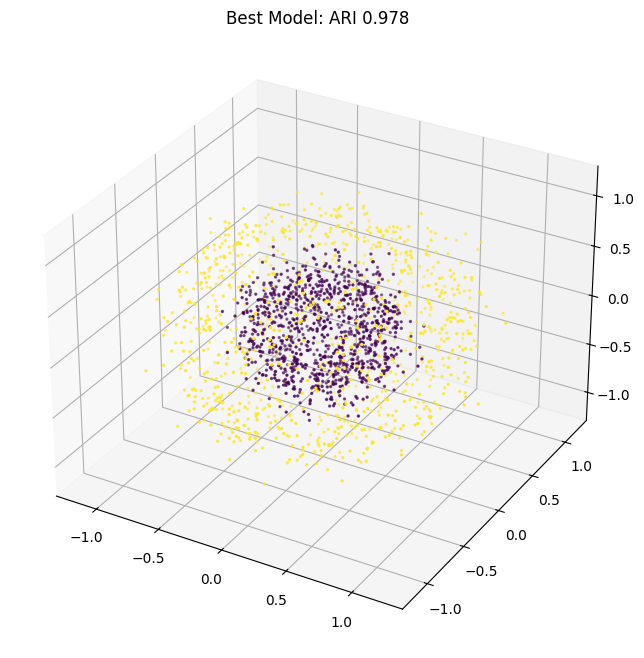

In [106]:
best_params = study.best_params
best_params = unflatten_dict(best_params)
best_params = update_recursively(best_params, model_kwargs)
best_model = model_cls(**best_params)
labels = best_model.fit_predict(features_extended)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.scatter(features[:, 0], features[:, 1], features[:, 2], c=labels, cmap='viridis', s=2)
ax.set_title(f'Best Model: ARI {adjusted_rand_score(true_labels, labels):.3f}')
plt.show()

In [107]:
best_params

{'repetitions': 3,
 'transform_kwargs': {'gamma': 4.645312842796526, 'n_components': 500},
 'n_features': 2,
 'representative_method': 'rbf',
 'base_model': sklearn.cluster._kmeans.KMeans,
 'base_model_kwargs': {'n_clusters': 2},
 'transform_method': sklearn.kernel_approximation.RBFSampler,
 'random_state': 13,
 'sample_than_transform': True}

# More samples

In [9]:
n_samples = int(1e8)
n_features = 2
centers = 2
cluster_std = 1
random_state = 42
X, true_labels = dask_make_blobs(
    n_samples=n_samples,
    n_features=n_features,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state,
    chunks=int(1e6),
)

In [10]:
random_state_model = 42000
kmeans = LazyMiniBatchKMeans(n_clusters=centers, batch_size=int(1e6), random_state=random_state_model)
kmeans_labels = kmeans.fit_predict(X)

In [13]:
kmeans_labels = da.from_array(kmeans_labels, chunks=true_labels.chunksize)
ari_kmeans = dask_adjusted_rand_score(true_labels, kmeans_labels)
print(f"ARI KMeans: {ari_kmeans:.3f}")

ARI KMeans: 1.000


In [14]:
random_state_model = 42000
cohirf = ModularCoHiRF(
    repetitions=3,
    n_features=1,
    representative_method="closest_overall",
    random_state=random_state_model,
    base_model=KMeans,
    base_model_kwargs={"n_clusters": centers},
    sample_than_transform=True,
    batch_size=int(1e6),
)
cohirf_labels = cohirf.fit_predict(X)

: 